<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Agglomerative Hierarchical Clustering
              
</p>
</div>

DS-NTL-051324<p>Phase 4</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

## Learning Objectives

- describe the algorithms of agglomerative and divisive hierarchical clustering;
- compare and contrast hierarchical clustering with $k$-means clustering;
- implement hierarchical clustering with `scipy` and `sklearn`;
- build and interpret dendrograms.

In [1]:
# Imports

import sys, os
import seaborn as sns
ex_path = os.path.abspath(os.pardir)
if ex_path not in sys.path:
    sys.path.append(ex_path)

from src.hier_example import *
from sklearn.datasets import make_blobs
from src.av_link_agglom_clust import centrAggClust as ac
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.datasets import make_blobs, make_moons, load_iris
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from copy import deepcopy

%matplotlib inline

Often grouping within data is **hierarchical**:
- organisms: family/genus/species/subspecies/variants

- cosmic structure: superclusters, local superclusters, clusters/groups, galaxies

<center><img src = "Images/superclster.png" width = 800/></center>
<center> Laniakea galactic supercluster </center>

In many cases: 
- only have data
- want to discover multilevel cluster hierarchy

KMeans was not designed for this task:
- "Flat" clustering vs discovering group hierarchies.

## Hierarchical Agglomerative Clustering
Recall $k$-means clustering where the goal is to assign individual observations to a pre-specified number of clusters according to Euclidean distance between the centroid and the observation. Hierarchical clustering sets out to group the most similar two observations together from a bottom-up level. We end up with a tree-like diagram called a **dendrogram**, which allows us to view the clusterings obtained for each possible number of clusters, from 1 to n. It is up to our discretion as data scientists to decide how many clusters we want. 

![dendro](images/dendogram.png)

***
One disadvantage of $k$-means clustering is that we have to specify the number of clusters beforehand. The type of hierchical clustering we will learn today is **agglomerative**, or **bottom-up**, such that we do not have to specify the number of clusters beforehand. We will now dive into the details of hierchical clustering.

There is also **top-down** or **divisive** clustering, where one starts with the entire dataset as a single cluster.
***

### How does the algorithm work
Initially, every observation is its own cluster. As we move up the leaf of the dendrogram, the two most similar observations fuse together, and then the next most similar clusters fuse together etc. until everything fuses together into a big cluster. Where to stop is up to our discretion. 

![dendro2](images/400_Basic_Dendrogram.png)

Idea is:
- Group nearest neighbor members
- Based on some similarity/distance scheme.
- Then repeat.
- Finds higher order grouping at each stage.

<center><img src = "Images/hierarch.gif" /></center>
<center> Agglomerates at each stage. </center>

Clearly a bottom-up approach:
- Use data, metric/agglomeration scheme to discover hierarchies.

#### Decision making on cluster merging

Distance notions:
- Euclidean or Manhattan distance
- Hamming distance
- Damerau-Levenshtein distance


String comparison: Damerau-Levenshtein distance
- Number of operations: insertions, deletions, substitutions 
- Transposition of two adjacent characters.

<img src = "Images/damerau.gif" />


#### Merge criterion: cluster distance evaluation

Given a distance measure: still there are different ways to evaluate **cluster** distance.

- Known as **linkage** (i.e. how do we link clusters?)


Merge clusters with minimum linkage value

<img src = "Images/linkage_type.png" />

### Types of hierarchical agglomerative clustering 

The way that distance is measured between clusters is called the model's **linkage**.

- Single Linkage 
    -  Minimum pair-wise distance: for any two clusters, take one observation from each and determine their distance. Do this over and over, until you have identified the overall minimum pair-wise distance. 
- Complete Linkage
    -  Complete linkage may be defined as the furthest (or maximum) distance between two clusters. That is, all possible pairwise distances between elements (one from cluster A and one from B) are evaluated and the largest value is used as the distance between clusters A & B. This is sometimes called complete linkage and is also called furthest neighbor.
- Average Linkage
    - The distance between clusters is defined as the average distance between the data points in the clusters. 
- Ward Linkage
    -  Ward method finds the pair of clusters that leads to minimum increase in total within-cluster variance after merging at each step.

Each linkage method has it's uses:

[This article](https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec) describes the pros and cons of each approach.

#### Agglomerative Hierarchical Clustering in Python
- See it in action

- Scipy has nice functionality for this.

In [2]:
# defines metric and calculates pair-wise distance between points 
from scipy.spatial.distance import pdist 

#for reshaping distance matrix 
from scipy.spatial.distance import squareform


Load in some data

In [3]:
import pandas as pd
agg_data = pd.read_csv('Data/Aggregation.txt', header = None, usecols = [0,1], delimiter = '\t')
agg_data.columns = ['X', 'Y']
agg_data.head()

,X,Y
0,15.55,28.65
1,14.90,27.55
2,14.45,28.35
3,14.15,28.80
4,13.75,28.05


In [4]:
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       788 non-null    float64
 1   Y       788 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


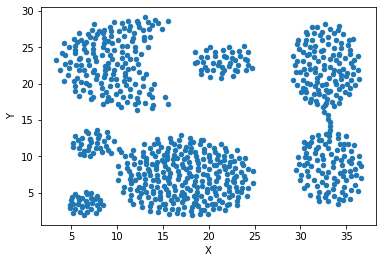

In [5]:
agg_data.plot(x = 'X', y = 'Y', kind = 'scatter');

Some hierarchical grouping here.

At each step:

- algorithm calculates matrix of linkage distances between clusters

In [6]:
#computes the pairwise distance and returns a condensed array
#removes diagonal terms and flattens array
condensed_dist = pdist(agg_data, metric = 'euclidean' ) 
condensed_dist

array([1.27769323, 1.14017543, 1.40801278, ..., 0.5       , 0.82764727,
       0.45276926])

Inspect in familiar matrix form
- Each column(row) indexes cluster
- Starting: each data points is their own cluster.

In [7]:
sqp = squareform(condensed_dist)
sqpdf = pd.DataFrame(sqp, index = agg_data.index,columns = agg_data.index)
sqpdf

,0,1,2,3,4,5,6,7,8,9,...,778,779,780,781,782,783,784,785,786,787
0,0.000000,1.277693,1.140175,1.408013,1.897367,2.209072,2.598557,2.394264,2.902585,3.041792,...,26.130107,25.774503,25.347830,25.757572,26.436717,26.460395,26.964050,26.360245,26.182294,25.736793
1,1.277693,0.000000,0.917878,1.457738,1.253994,1.792345,2.483948,1.450862,1.671077,2.109502,...,24.871269,24.523509,24.104045,24.512242,25.189730,25.220032,25.728632,25.128669,24.944739,24.498265
2,1.140175,0.917878,0.000000,0.540833,0.761577,1.104536,1.656050,1.312440,2.035927,1.929378,...,25.472976,25.148062,24.746363,25.150795,25.824020,25.869335,26.387876,25.795591,25.600049,25.151789
3,1.408013,1.457738,0.540833,0.000000,0.850000,0.873212,1.202082,1.476482,2.364847,1.981161,...,25.805135,25.494166,25.103386,25.505392,26.175800,26.230231,26.754672,26.167251,25.964688,25.515485
4,1.897367,1.253994,0.761577,0.850000,0.000000,0.565685,1.331353,0.626498,1.557241,1.180042,...,24.968831,24.663434,24.277819,24.678584,25.347584,25.406544,25.934147,25.349606,25.143041,24.693370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,26.460395,25.220032,25.869335,26.230231,25.406544,25.706274,26.318815,24.802117,23.865509,24.515301,...,1.835756,1.180042,1.151086,0.824621,0.585235,0.000000,0.650000,0.707107,0.360555,0.738241
784,26.964050,25.728632,26.387876,26.754672,25.934147,26.240808,26.860054,25.332242,24.389854,25.054391,...,2.381701,1.817966,1.761391,1.470544,1.131371,0.650000,0.000000,0.672681,0.801561,1.253994
785,26.360245,25.128669,25.795591,26.167251,25.349606,25.662473,26.288020,24.750051,23.802783,24.480605,...,2.507987,1.750000,1.408900,1.272792,1.285496,0.707107,0.672681,0.000000,0.500000,0.827647
786,26.182294,24.944739,25.600049,25.964688,25.143041,25.447446,26.064727,24.540273,23.599841,24.259637,...,2.024846,1.250000,0.982344,0.781025,0.850000,0.360555,0.801561,0.500000,0.000000,0.452769


At each iteration, merges clusters with minimum pairwise distance:
- Merged cluster is new *supercluster*
- For $n$ datapoints continues this $n-1$ times.
- Entire sequence of merges gives us entire hierarchy of clusters.

<center><img src = "Images/hierarch.gif" /></center>
<center> Agglomerates at each stage. </center>

scipy's linkage function:
- linkage(condensed pair-wise distance, method)
- returns an entire sequence of cluster merges in agglomerative process.

In [8]:
from scipy.cluster.hierarchy import linkage

In [9]:
np_linkage = linkage(condensed_dist, method='ward')

In [10]:
cols = ['clst1', 'clst2', 'dist', 'num_points']
linkage_df = pd.DataFrame(np_linkage,
                          columns = cols)
linkage_df.index.name = 'merge'
linkage_df

,clst1,clst2,dist,num_points
merge,,,,
0,185.0,186.0,0.111803,2.0
1,671.0,672.0,0.150000,2.0
2,79.0,80.0,0.158114,2.0
3,433.0,434.0,0.158114,2.0
4,366.0,367.0,0.180278,2.0
...,...,...,...,...
782,1549.0,1565.0,91.581936,175.0
783,1567.0,1569.0,109.894662,341.0
784,1562.0,1570.0,158.954338,277.0


Rows: Cluster merges

- 788 data points: 788 - 1 merges

- Columns: clusters merged, distance between clusters, number of points in new cluster

In [11]:
print(linkage_df.shape)

(787, 4)


#### Creating the dendrogram
- scipy's dendrogram function

In [12]:
from scipy.cluster.hierarchy import dendrogram

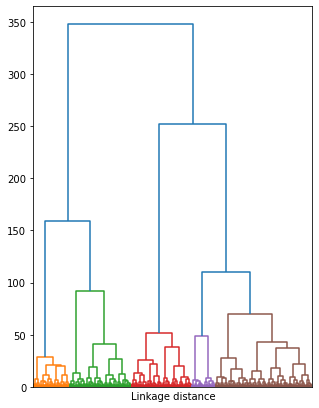

In [16]:
fig, ax = plt.subplots(figsize = (5,7))
dendrogram(linkage_df , no_labels = True, leaf_font_size = 8, color_threshold = 100)#,  orientation = 'up' )
ax.set_xlabel('Linkage distance')
plt.show()

At given linkage distance threshold:
- want to output "flattened" cluster assignments:
- scipy's fcluster function: fcluster(linkage_matrix, threshold, criterion)

In [17]:
from scipy.cluster.hierarchy import fcluster
from copy import deepcopy

In [18]:

# criterion as linkage distance is fairly common
clust_assgn = fcluster(linkage_df, t = 50, criterion = 'distance')

#put labels into dataframe and scatterplot
agg_assigned = deepcopy(agg_data)
agg_assigned['label'] = clust_assgn

In [19]:
agg_assigned.head()

,X,Y,label
0,15.55,28.65,5
1,14.90,27.55,5
2,14.45,28.35,5
3,14.15,28.80,5
4,13.75,28.05,5


Scatterplot with hue on cluster assignments

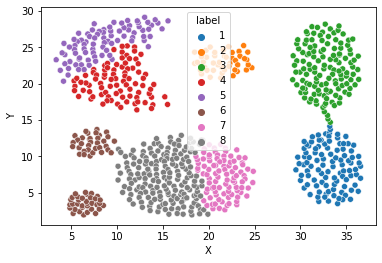

In [20]:
n_labels = len(agg_assigned['label'].unique())
fig, ax = plt.subplots(figsize = (6,4))
sns.scatterplot(x = 'X', y = 'Y',
                hue = 'label', 
                data = agg_assigned, 
                palette=sns.color_palette(
                    'tab10', n_labels), ax = ax)

plt.show()

In [21]:
def plot_with_threshold(data, linkage, threshold = 100):
    
    clust_assgn = fcluster(linkage, t = threshold, criterion = 'distance')
    
    agg_assigned = deepcopy(data)
    agg_assigned['label'] = clust_assgn
    n_labels = len(agg_assigned['label'].unique())
    

    fig, ax = plt.subplots(1,2, figsize = (8,5))
    d = dendrogram(linkage, no_labels = True, leaf_font_size = 8,
               color_threshold = threshold, orientation = 'left', ax = ax[0] )
    ax[0].set_xlabel('Linkage distance')
    
    ax[0].axvline(threshold, c = 'b', linestyle = '--')
    
    #NEW CODE
    ax[1].scatter(agg_assigned['X'].iloc[d['leaves']], 
                  agg_assigned['Y'].iloc[d['leaves']], 
                  color=d['leaves_color_list'])

    plt.show()

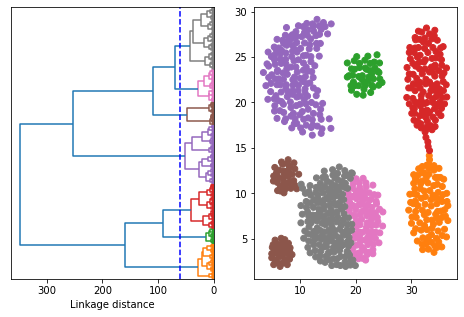

In [28]:

plot_with_threshold(agg_data, linkage_df, 60)

#### Evaluating the agglomerative linkage and dendrogram

#### Cophenetic distances

- Taking point $i$ and $j$: 
- linkage distance between respective clusters before merge.



<center><img src = "Images/cophen_dist.jpg" width = 400/></center>

### How well does the dendrogram fit the data?

One way of computing this is by means of the **cophenetic correlation coefficient**, which, in a word, is a measure of "how faithfully the dendrogram preserves the pairwise distances between the \[datapoints\]" -- [Wikipedia](https://en.wikipedia.org/wiki/Cophenetic_correlation).

The cophenetic correlation coefficient $c$ is given by [ref](https://www.mathworks.com/help/stats/index.html?/access/helpdesk/help/toolbox/stats/cophenet.html=)

![c-coef](images/cophenet.png)


$x(i, j) = | Xi − Xj |$, the ordinary Euclidean distance between the $i$th and $j$th observations.<br>
$t(i, j)$ = the dendrogrammatic distance between the model points $Ti$ and $Tj$. This distance is the height of the node at which these two points are first joined together.<br>

Then, letting ${\bar {x}}$ be the average of the $x(i, j)$, and letting ${\bar {t}}$ be the average of the $t(i, j)$, the cophenetic correlation coefficient $c$ is given by[4]

This is complicated! [This site](https://people.revoledu.com/kardi/tutorial/Clustering/Online-Hierarchical-Clustering.html) is helpful on how to understand the cophenetic correlation, and, indeed, on hierarchical clustering generally.

**Cophenetic correlation coefficient**

- correlation between point pairwise distance and linkage distance at which pairs are joined.

- how closely related is the agglomerative clustering to the underlying data structure?


- Is a correlation coefficient: 
    - 1 = perfect correlation
    - 0 = no correlation
    - -1 = anti-correlation

In [29]:
from scipy.cluster.hierarchy import cophenet

Takes in linkage matrix and reduced pairwise distance matrix:
- returns correlation and list of cophenetic distances.

In [30]:
# evaluate effectiveness of hierarchical clustering with cophenetic correlation
corr_coef, cophen_dist = cophenet(np_linkage, condensed_dist)
print(corr_coef)

0.7838115721710462


The cophenetic correlation is measuring how effective our agglomerative clustering is at capturing the entire **hierarchy**.

#### Hierarchical clustering with `sklearn` 

- Scipy has much better functionality for exploring full hierarchy
- Sklearn for using hierarchical clustering in flat clustering/prediction tasks
- can specify number of clusters, adjusts threshold automatically.


In [31]:
from sklearn.cluster import AgglomerativeClustering

In [32]:
# affinity is distance metric(euclidean, manhattan)
# linkage (average, complete, single, ward, etc.)
agg_cluster = AgglomerativeClustering(n_clusters = 7,
                                      affinity = 'euclidean', 
                                      linkage = 'average')
agg_cluster

AgglomerativeClustering(linkage='average', n_clusters=7)

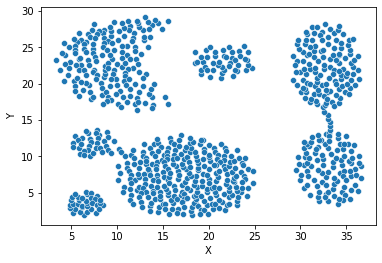

In [33]:
sns.scatterplot(x = 'X', y = 'Y', data = agg_data)
plt.show()

In [34]:
agg_labels = agg_cluster.fit_predict(agg_data)
sklearn_agg_data = deepcopy(agg_data)
sklearn_agg_data['labels'] = agg_labels
sklearn_agg_data.head()

,X,Y,labels
0,15.55,28.65,0
1,14.90,27.55,0
2,14.45,28.35,0
3,14.15,28.80,0
4,13.75,28.05,0


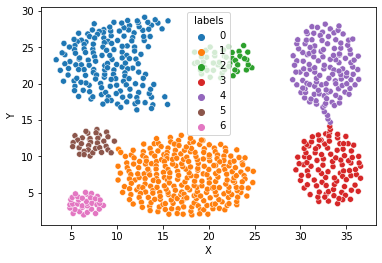

In [35]:
sns.scatterplot(x = 'X', y = 'Y', 
                hue = 'labels', palette = 'tab10',
                data = sklearn_agg_data)
plt.show()

Benefit of sklearn implementation:
- Chooses distance threshold for you given number of clusters.

#### Evaluation

Operating in this flat mode:
- getting reasonable cluster number -- silhouette score.
- not a sure fire method but not terrible either.

In [36]:
def plot_silh_scores(X, K, increment, linkage):

    klist = np.arange(2,K,increment)
    score_list = []
    for k in klist:
        agg_clstrer = AgglomerativeClustering(n_clusters = k,
                                      affinity = 'euclidean', 
                                      linkage = linkage)
        
        clstr_labels = agg_clstrer.fit_predict(X)

        score = silhouette_score(X, clstr_labels)
        score_list.append(score)
        
    sns.lineplot(x = klist, y = score_list, color = 'r')
    plt.ylabel('Silhouette Coefficient')
    plt.xlabel('K')
    plt.title('Silhouette coefficient plot')
    plt.show()

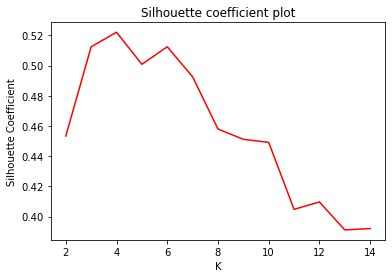

In [37]:
plot_silh_scores(agg_data, 15, 1, 'average')

Under average linkage:
- k = 6 might be a good choice.

In [38]:
def plot_with_sklearn(X, k, linkage):
    agg_cluster = AgglomerativeClustering(n_clusters = k,
                                      affinity = 'euclidean', 
                                      linkage = linkage)
    
    agg_labels = agg_cluster.fit_predict(X)
    sklearn_agg_data = deepcopy(X)
    sklearn_agg_data['labels'] = agg_labels
    
    sns.scatterplot(x = 'X', y = 'Y', 
                hue = 'labels', palette = 'tab10',
                data = sklearn_agg_data)
    plt.show()


- Seven is actually the optimal number for the flat clustering.
- Clustering is a tricky business and often requires human judgement.
- Sklearn's API makes it easy for agglomerative clustering: don't have to mess with thresholds.

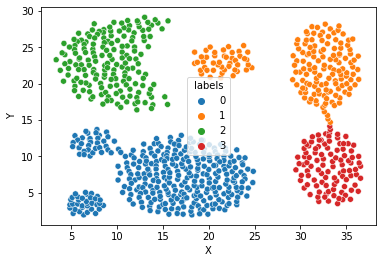

In [39]:
plot_with_sklearn(agg_data, 4, 'average')

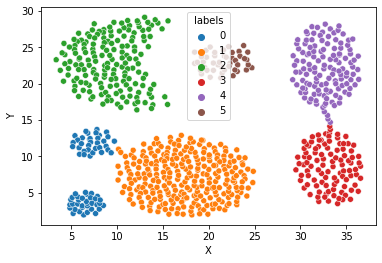

In [40]:
plot_with_sklearn(agg_data, 6, 'average')

But:

- agglomerative hierarchical clustering for flat clustering tasks: SLOW.
- designed to calculate whole hierarchy.
- better methods for flat clustering: kmeans, DBSCAN, mixture methods, variational autoencoders, etc.

### Evaluating number of clusters / Cut points
For hierarchical agglomerative clustering, or clustering in general, it is generally difficult to truly evaluate the results. Therefore, it is up you, the data scientists, to decide.

**[Stanford has a good explanation on page 380](https://nlp.stanford.edu/IR-book/pdf/17hier.pdf)** of your options for picking the cut-off. 

When we are viewing dendrograms for hierarchical agglomerative clustering, we can visually examine where the natural cutoff is, despite it not sounding exactly statistical, or scientific. We might want to interpret the clusters and assign meanings to them depending on domain-specific knowledge and shape of dendrogram. However, we can evaluate the quality of our clusters using measurements such as Sihouette score discussed in the k-means lectures. 

## Advantages & Disadvantages of hierarchical clustering

#### Advantages
- Intuitive and easy to implement
- More informative than k-means because it takes individual relationship into consideration
- Allows us to look at dendrogram and decide number of clusters

#### Disadvantages
- Very sensitive to outliers
- Cannot undo the previous merge, which might lead to problems later on 

### Further reading

- [from MIT on just hierarchical](http://web.mit.edu/6.S097/www/resources/Hierarchical.pdf)
- [from MIT comparing clustering methods](http://www.mit.edu/~9.54/fall14/slides/Class13.pdf)
- [fun CMU slides on clustering](http://www.cs.cmu.edu/afs/andrew/course/15/381-f08/www/lectures/clustering.pdf)